# A simple example to understand BatchNormalization layer as input layer

$$
Ana Gorodisch^{1}, Ivan Anduaga Marchetti^{2}, Delfina Villeri^3, Elmer A. Fernández^4
$$

<span style="font-size: 10px;">
1 Data Scientist at Embryoxite<br>
2 CSO at Embryoxite<br>
3 CEO at Embryoxite<br>
4 DataLab, Fundación para el progreso de la Medicina, CONICET<br><br>
Corresponding Author: Elmer A. Fernández elmerfernandez at fpmlab.org.ar
</span>

In this document, we present the results of our analysis as well as the code required to replicate them.




## Mount this file to your Google Drive



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import necessary libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
from scipy.stats import linregress
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import StandardScaler

## BatchNormalization Layer allows a lesser number of learnable parameters

In a previous study, the optimal architectures for the DLNNnorm and DLNNe2e models for the regression task were identified. During the same study, these models were trained for this task, and their checkpoints are available at the following file paths.

In [3]:
DLNNnorm_checkpoint_path = 'optimal_model_checkpoints/DLNNnorm.h5'
DLNNe2e_checkpoint_path = 'optimal_model_checkpoints/DLNNe2e.h5'

In [4]:
DLNNnorm = tf.keras.models.load_model(DLNNnorm_checkpoint_path)
DLNNe2e = tf.keras.models.load_model(DLNNe2e_checkpoint_path)

DLNN norm yields 85 trainable parameters

In [5]:
DLNNnorm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6)                 36        
                                                                 
 activation_2 (Activation)   (None, 6)                 0         
                                                                 
 dense_5 (Dense)             (None, 6)                 42        
                                                                 
 activation_3 (Activation)   (None, 6)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 7         
                                                                 
Total params: 85 (340.00 Byte)
Trainable params: 85 (340.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


DLNNe2e yields 87 parameters, 65 trainable parameters and 22 non-trainable

In [6]:
DLNNe2e.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 5)                 20        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 6)                 36        
                                                                 
 batch_normalization_1 (Bat  (None, 6)                 24        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 87 (348.00 Byte)
Trainable params: 65 (260

The following figure shows the architecture for both models

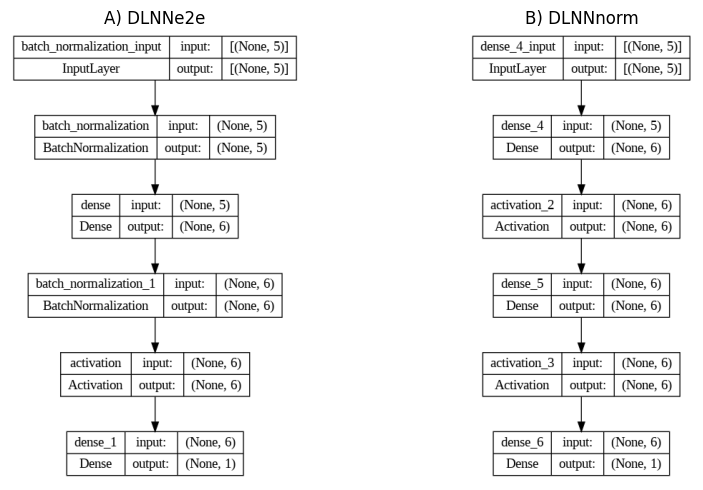

In [7]:
plt.figure(figsize=(10, 5))

# Subplot for DLNNe2e
plt.subplot(1, 2, 1)
plt.title('A) DLNNe2e')
plot_model(DLNNe2e, to_file='model_dlnne2e.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_dlnne2e.png')
plt.imshow(img)
plt.axis('off')

# Subplot for DLNNnorm
plt.subplot(1, 2, 2)
plt.title('B) DLNNnorm')
plot_model(DLNNnorm, to_file='model_dlnnnorm.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_dlnnnorm.png')
plt.imshow(img)
plt.axis('off')

plt.tight_layout()
plt.show()

## Sensitivity analysis reveal that the BN scale parameter (gamma) is related to the input variable importance on prediction

### Import and preprocess raw data

The following file path contains the CSV file with the dataset used in this example.

In [8]:
data_path = 'Urea.csv'

In [9]:
data = pd.read_csv(data_path)

print(f'The CSV file has {data.shape[0]} samples and {data.shape[1]} features for each sample')
print(f'The CSV file contains the following information for each sample:\n{data.columns}')

The CSV file has 129 samples and 11 features for each sample
The CSV file contains the following information for each sample:
Index(['Upre', 'U120', 'Upos', 'PP', 'UF', 'Ueq', 'Uann', 'centro', 'Req',
       'Uf/pp', 'Ktveq'],
      dtype='object')


We should eliminate rows where Ueq is lower than Upos, as this is biologically incorrect.

In [11]:
rows_to_eliminate = data.loc[data['Ueq'] < data['Upos']]

if not rows_to_eliminate.empty:
    print("In the following samples Ueq is lower than Upos:")
    display(rows_to_eliminate)
else:
    print("Every Ueq value is equal or higher to Upos.")

print(f"\nThere are {len(rows_to_eliminate)} samples where Ueq is lower than Upos.")

In the following samples Ueq is lower than Upos:


,Upre,U120,Upos,PP,UF,Ueq,Uann,centro,Req,Uf/pp,Ktveq
8,123,68,51,76.9,3.2,49.0,50.4,1,0.398374,0.041612,1.120819
20,157,92,96,67.3,4.3,77.0,89.1,1,0.490446,0.063893,0.941477
23,122,99,93,88.5,5.5,86.0,87.9,1,0.704918,0.062147,0.513294
29,207,76,55,61.7,2.0,51.0,63.3,1,0.246377,0.032415,1.645721
31,137,84,72,119.0,4.1,63.0,56.0,1,0.459854,0.034454,0.939257
32,142,117,80,85.3,2.2,78.0,83.3,1,0.549296,0.025791,0.719805
43,112,49,38,86.0,3.0,35.0,49.4,1,0.312500,0.034884,1.378013
46,165,90,71,80.0,1.0,66.0,63.9,1,0.400000,0.012500,1.034672
50,133,68,49,65.0,2.0,46.0,50.4,1,0.345865,0.030769,1.249944
53,69,28,30,64.5,2.5,20.0,49.3,1,0.289855,0.038760,1.476692



There are 20 samples where Ueq is lower than Upos.


In [12]:
clean_data = data.drop(rows_to_eliminate.index)

if len(clean_data) != len(data):
    print(f'{len(rows_to_eliminate)} rows were eliminated')
    print(f'The new dataframe has {len(clean_data)} rows')
else:
    print('No rows were eliminated')

20 rows were eliminated
The new dataframe has 109 rows


In [13]:
clean_data

,Upre,U120,Upos,PP,UF,Ueq,Uann,centro,Req,Uf/pp,Ktveq
0,121,63,47,94.5,2.9,51.0,49.5,1,0.421488,0.030688,1.026871
1,166,87,68,59.4,1.4,71.0,70.5,1,0.427711,0.023569,0.991105
2,196,68,40,61.6,1.9,42.0,51.4,1,0.214286,0.030844,1.805728
3,167,73,43,45.7,2.6,43.0,54.2,1,0.257485,0.056893,1.673126
4,128,64,46,54.8,1.1,46.0,49.9,1,0.359375,0.020073,1.175300
...,...,...,...,...,...,...,...,...,...,...,...
124,196,98,79,79.0,4.0,89.0,75.4,0,0.454082,0.050633,0.996114
125,160,63,35,60.0,2.0,40.0,42.9,0,0.250000,0.033333,1.631594
126,142,77,50,73.0,2.0,58.0,57.5,0,0.408451,0.027397,1.052986
127,181,98,69,86.0,2.0,78.0,69.3,0,0.430939,0.023256,0.981904


Please note that when deleting rows, the indices of each sample no longer match the position of that sample in the dataframe.

### Import the model checkpoints for the DLNNe2e models from a 10-fold cross-validation




To replicate the exact results, import the models previously trained for this study. For your own training, refer to the **model_training_10fold.ipynb** file.

In [14]:
DLNNe2e_file_paths = 'DLNNe2e_10fold_model_checkpoints/'

The results_path points to a pickle file containing the results of the 10-fold cross-validation models trained for the regression task. This file includes important parameters from each model, which are essential for the subsequent analysis.

In [41]:
results_path = 'DLNNe2e_10fold_model_checkpoints/results.pickle'

In [42]:
with open(results_path, 'rb') as f:
    results = pickle.load(f)

This pickle file contains a list of 10 dictionaries, one for each fold.

In [43]:
len(results)

10

In [44]:
results[0].keys()

dict_keys(['DLNNe2e'])

This dictonary contains the following information:


*   **split**: indices for the train/val/test subsets

*   **hidden_layer_weights**: weights for the hidden layer

*   **scaler_mean**: StandardScaler mean

*   **scaler_std**: StandardScaler standard deviation

*   **bn_layer_params**: mu, sigma, beta and gamma parameters from the batch normalization layer

*   **mean_prediction_error**: mean for the prediction error across all samples

*   **std_prediction_error**: standard deviation for the prediction error across all samples

*   **mean_percentage_error**: mean for the percentage error for the prediction across all samples

*   **std_percentage_error**: standard deviation for the percentage error for the prediction across all samples

*   **predictions**: predictions for the test set

*   **true_value**: true value for the test set










In [45]:
results[0]['DLNNe2e'].keys()

dict_keys(['split', 'hidden_layer_weights', 'scaler_mean', 'scaler_std', 'bn_layer_params', 'mean_prediction_error', 'std_prediction_error', 'mean_percentage_error', 'std_percentage_error', 'predictions', 'true_value'])

### Begin testing

The initial step involves splitting the dataframe into explanatory variables (X_full) and response variables (Ueq). It's important to note that we stored sample indices to preserve train/val/test partitions across folds. Therefore, we will work with the unfiltered dataframe to ensure correct row selection in subsequent tests.

In [46]:
X_full = data[['Upre', 'U120', 'Upos', 'PP', 'UF']]
y_full = data['Ueq']

####Distribution of the test set input variables for all 10 folds.
A) Raw data

B) Z-score normalized data

C) Normalized data by the moving average and standard deviation from de Batch Normalization layer

D) Output from the Batch Normalization layer

In [ ]:
raw_data = []
scaler_normalization = []
BN_normalization = []
output_BN = []

for i in range(len(results)):
    indices = results[i]['DLNNe2e']['split']['test_indices']
    X_test = X_full.iloc[indices]
    y_test = y_full.iloc[indices]

    raw_data.append(X_test)

    mean_scaler = results[i]['DLNNe2e']['scaler_mean']
    std_scaler = results[i]['DLNNe2e']['scaler_std']

    X_test_normalized = X_test.copy()

    for column in X_test_normalized.columns:
        columns_index = X_test_normalized.columns.get_loc(column)
        X_test_normalized[column] = (X_test_normalized[column] - mean_scaler[columns_index]) / std_scaler[columns_index]

    scaler_normalization.append(X_test_normalized)

    mu = results[i]['DLNNe2e']['bn_layer_params'][0]
    sd = results[i]['DLNNe2e']['bn_layer_params'][1]

    X_test_normalized_BN = X_test.copy()

    for column in X_test_normalized_BN.columns:
        column_index = X_test_normalized_BN.columns.get_loc(column)
        X_test_normalized_BN[column] = (X_test_normalized_BN[column] - mu[column_index]) / sd[column_index]

    BN_normalization.append(X_test_normalized_BN)

    model = tf.keras.models.load_model(f"{DLNNe2e_file_paths}DLNNe2e_{i}.h5")

    intermediate_layer = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)
    out_BN = intermediate_layer.predict(X_test)

    output_BN.append(out_BN)

In [48]:
raw_data_df = pd.concat(raw_data, ignore_index=True)
scaler_normalization_df = pd.concat(scaler_normalization, ignore_index=True)
BN_normalization_df = pd.concat(BN_normalization, ignore_index=True)

In [49]:
output_BN_flat = [vector for list in output_BN for vector in list]
BN_df = pd.DataFrame(output_BN_flat)
BN_df.columns = raw_data_df.columns

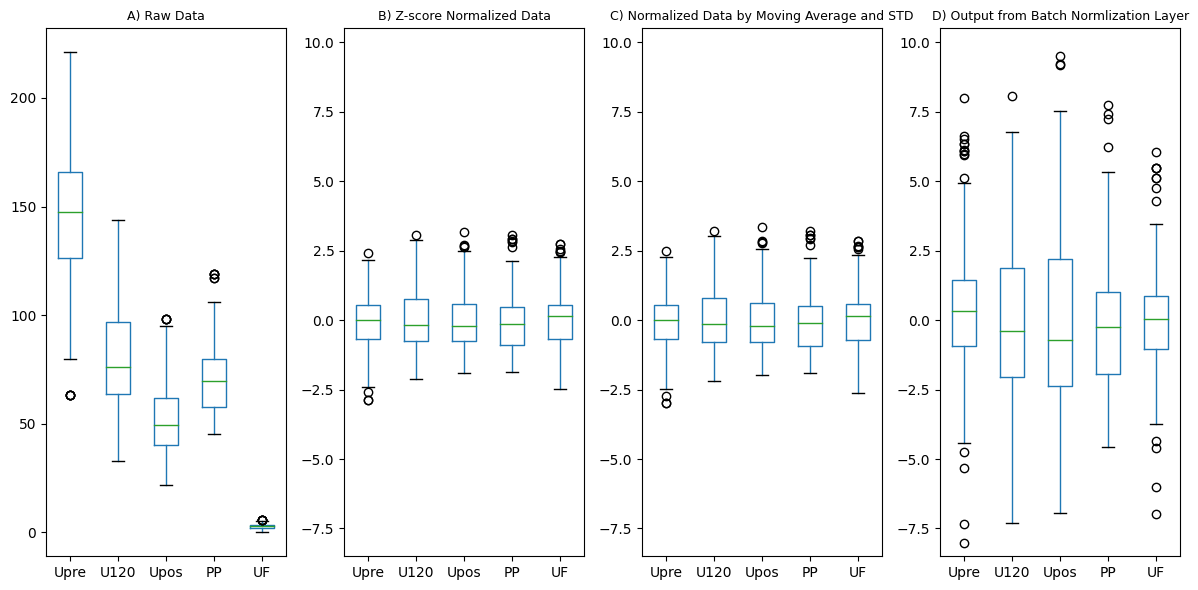

In [50]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

datasets = [raw_data_df, scaler_normalization_df, BN_normalization_df, BN_df]

titles = ['A) Raw Data', 'B) Z-score Normalized Data', 'C) Normalized Data by Moving Average and STD', 'D) Output from Batch Normlization Layer']

for i, dataset in enumerate(datasets):

    ax = axs[i]
    dataset.boxplot(ax=ax)
    ax.set_title(titles[i], fontsize = 9)
    ax.grid(False)

    if i > 0:
        ax.set_ylim(-8.5, 10.5)

plt.tight_layout()
plt.show()

####Z-score normalization parameters as well as the BN parameters for each variable. The table depicts, for each value, its average and standard deviation across the 10 folds.

In [51]:
# Create lists to store bn_layer_params
mu = []
std = []
beta = []
gamma = []

for i in range(10):
    mu_i = results[i]['DLNNe2e']['bn_layer_params'][0]
    mu.append(mu_i)
    std_i = results[i]['DLNNe2e']['bn_layer_params'][1]
    std.append(std_i)
    beta_i = results[i]['DLNNe2e']['bn_layer_params'][2]
    beta.append(beta_i)
    gamma_i = results[i]['DLNNe2e']['bn_layer_params'][3]
    gamma.append(gamma_i)

# Convert lists into numpy arrays
mu = np.array(mu)
std = np.array(std)
beta = np.array(beta)
gamma = np.array(gamma)

# Calculate mean and standard deviation for each element
means_mu = np.mean(mu, axis=0)
deviations_mu = np.std(mu, axis=0)
means_std = np.mean(std, axis=0)
deviations_std = np.std(std, axis=0)
means_beta = np.mean(beta, axis=0)
deviations_beta = np.std(beta, axis=0)
means_gamma = np.mean(gamma, axis=0)
deviations_gamma= np.std(gamma, axis=0)

# Create an array with the mean and standard deviation of each element
result_mu = np.vstack([means_mu, deviations_mu])
result_std = np.vstack([means_std, deviations_std])
result_beta = np.vstack([means_beta, deviations_beta])
result_gamma = np.vstack([means_gamma, deviations_gamma])

In [52]:
# Create lists to store Scaler parameters
mean = []
ds = []

for i in range(10):
    mean_i = results[i]['DLNNe2e']['scaler_mean']
    mean.append(mean_i)
    ds_i = results[i]['DLNNe2e']['scaler_std']
    ds.append(ds_i)

# Convert lists into numpy arrays
mean = np.array(mean)
ds = np.array(ds)

# Calculate mean and standard deviation for each element
means_mean = np.mean(mean, axis=0)
deviations_mean = np.std(mean, axis=0)
means_ds = np.mean(ds, axis=0)
deviations_ds = np.std(ds, axis=0)

# Create an array with the mean and standard deviation of each element
result_mean = np.vstack([means_mean, deviations_mean])
result_ds = np.vstack([means_ds, deviations_ds])

In [53]:
variables = ['Upre', 'U120', 'Upos', 'PP', 'UF']
parametres = ['μ', 'std', 'beta', 'gamma', 'mean_scaler', 'std_scaler']

data_parametres = {
    'μ': result_mu,
    'std': result_std,
    'beta': result_beta,
    'gamma': result_gamma,
    'mean_scaler': result_mean,
    'std_scaler': result_ds
}

df = pd.DataFrame(index=variables)

for param in parametres:
    means = data_parametres[param][0]
    deviations = data_parametres[param][1]
    for variable, avg, deviation in zip(variables, means, deviations):
        if param == 'beta':
            df.loc[variable, param] = f"{avg:.2e} ± {deviation:.2e}"
        else:
            df.loc[variable, param] = f"{avg:.2f} ± {deviation:.2f}"

data_list = df.values.tolist()
column_names = df.columns.tolist()
row_names = df.index.tolist()

data_list.insert(0, column_names)

for i, row_name in enumerate(row_names):
    data_list[i+1].insert(0, row_name)

table = tabulate(data_list, headers='firstrow', tablefmt='fancy_grid')

print(table)

╒══════╤═══════════════╤══════════════╤══════════════════════╤═════════════╤═══════════════╤══════════════╕
│      │ μ             │ std          │ beta                 │ gamma       │ mean_scaler   │ std_scaler   │
╞══════╪═══════════════╪══════════════╪══════════════════════╪═════════════╪═══════════════╪══════════════╡
│ Upre │ 148.89 ± 3.27 │ 32.27 ± 1.15 │ 1.60e-07 ± 2.66e-07  │ 1.58 ± 1.75 │ 149.09 ± 2.99 │ 33.56 ± 1.19 │
├──────┼───────────────┼──────────────┼──────────────────────┼─────────────┼───────────────┼──────────────┤
│ U120 │ 79.36 ± 2.16  │ 22.03 ± 0.70 │ 4.47e-08 ± 5.01e-07  │ 1.61 ± 1.91 │ 79.52 ± 1.88  │ 22.89 ± 0.61 │
├──────┼───────────────┼──────────────┼──────────────────────┼─────────────┼───────────────┼──────────────┤
│ Upos │ 53.00 ± 1.55  │ 15.94 ± 0.66 │ -3.61e-08 ± 9.67e-07 │ 3.27 ± 0.57 │ 53.19 ± 1.48  │ 16.62 ± 0.61 │
├──────┼───────────────┼──────────────┼──────────────────────┼─────────────┼───────────────┼──────────────┤
│ PP   │ 72.18 ± 1.21  │ 16.

#### MSPE upon turning off each variable versus its respective gamma

In [ ]:
predictor_variables = ['Upre', 'U120', 'Upos', 'PP', 'UF']

gamma_flat = gamma.flatten()

with pd.ExcelWriter('sensitivity_analysis.xlsx', engine='openpyxl') as writer:
    all_splits_df = pd.DataFrame()

    for i in range(10):
        model = tf.keras.models.load_model(f'{DLNNe2e_file_paths}DLNNe2e_{i}.h5')
        test_indices = results[i]['DLNNe2e']['split']['test_indices']

        X_test = X_full.iloc[test_indices]
        y_test = y_full.iloc[test_indices]

        # Create dataframe to store results
        df = pd.DataFrame(columns=['mean error', 'std error', 'mean_percent_error', 'std_percent_error'])

        # Evaluate 'turning off' one variable at a time
        for j in range(len(predictor_variables)):
            X_test_modified = X_test.copy()
            X_test_modified.iloc[:, j] = 0
            y_pred_modified = model.predict(X_test_modified)

            errors_mod = y_pred_modified.flatten() - y_test
            percent_errors_mod = (errors_mod/y_test)*100
            mean_errors_mod = np.mean(errors_mod)
            std_errors_mod = np.std(errors_mod)
            mean_percent_errors_mod = np.mean(percent_errors_mod)
            std_percent_errors_mod = np.std(percent_errors_mod)

            # Store results in dataframe
            df.loc[predictor_variables[j]] = [mean_errors_mod, std_errors_mod, mean_percent_errors_mod, std_percent_errors_mod]

        # Concatenate all splits
        all_splits_df = pd.concat([all_splits_df, df], axis=0)

        # Escribir el DataFrame en la hoja correspondiente del Excel
        df.to_excel(writer, sheet_name=f'fold_{i}')

    all_splits_df['gamma']= gamma_flat
    abs_error = all_splits_df['mean error'].abs()
    abs_gamma = all_splits_df['gamma'].abs()
    all_splits_df['abs_error'] = abs_error
    all_splits_df['abs_gamma'] = abs_gamma

    # Escribir el DataFrame concatenado en una nueva hoja llamada 'all_splits'
    all_splits_df.to_excel(writer, sheet_name='all_splits')

In [98]:
all_splits_df = pd.read_excel('sensitivity_analysis.xlsx', sheet_name='all_splits')

In [99]:
all_splits_df

,Unnamed: 0,mean error,std error,mean_percent_error,std_percent_error,gamma,abs_error,abs_gamma
0,Upre,3.275184,15.582744,8.657463,21.707287,-1.206181,3.275184,1.206181
1,U120,-26.103016,13.493329,-42.930063,11.577071,2.855051,26.103016,2.855051
2,Upos,-14.701238,14.347115,-21.585785,16.959677,3.294642,14.701238,3.294642
3,PP,3.297141,14.282485,9.799304,20.935388,2.369529,3.297141,2.369529
4,UF,-0.030646,14.468869,3.308658,20.405035,1.810435,0.030646,1.810435
5,Upre,-6.848600,12.224031,-7.857635,18.406343,2.943468,6.848600,2.943468
6,U120,-13.286487,14.674996,-16.672998,18.317358,2.235906,13.286487,2.235906
7,Upos,-20.887942,15.216908,-29.704456,18.509004,2.771394,20.887942,2.771394
8,PP,1.671810,11.816571,2.194282,18.353710,1.353866,1.671810,1.353866
9,UF,2.700310,8.452790,5.980021,15.154521,1.209243,2.700310,1.209243


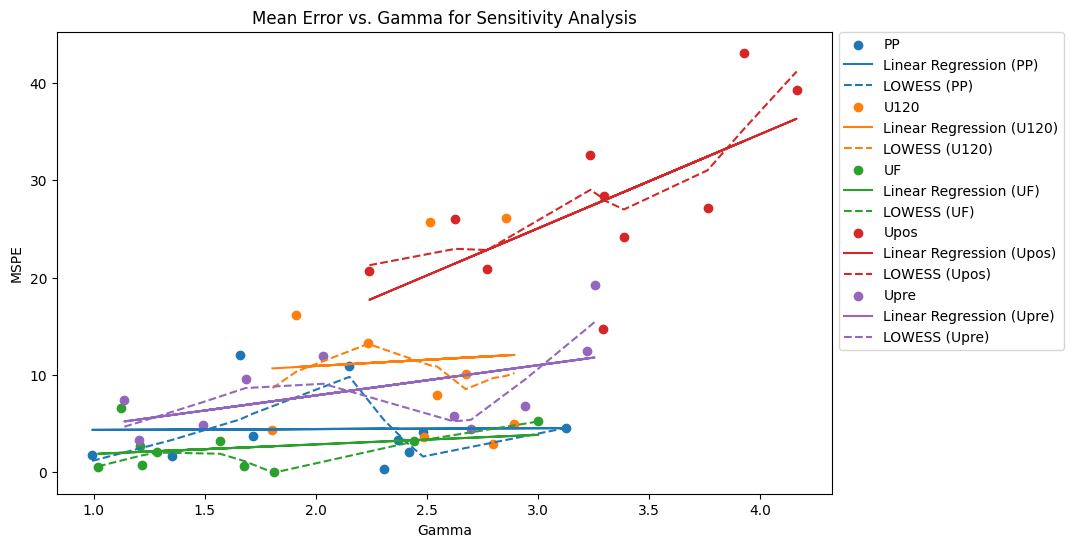

In [100]:
fig, axs = plt.subplots(1, figsize=(10, 6))

for category, group in all_splits_df.groupby('Unnamed: 0'):
    # Calculate Regression Line
    slope, intercept, r_value, p_value, std_err = linregress(abs(group['gamma']), abs(group['mean error']))

    # Scatter Graph
    scatter = axs.scatter(abs(group['gamma']), abs(group['mean error']), label=category)
    color = scatter.get_facecolor()[0]  # Get color from scatter points

    # Regression Line
    axs.plot(abs(group['gamma']), slope * abs(group['gamma']) + intercept, linestyle='-', color=color, label=f'Linear Regression ({category})')

    # Calculate LOWESS Smoothing
    loess_smoothed = lowess(abs(group['mean error']), abs(group['gamma']), frac=0.6)
    axs.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], linestyle='--', color=color, label=f'LOWESS ({category})')

axs.set_title('Mean Error vs. Gamma for Sensitivity Analysis')
axs.set_xlabel('Gamma')
axs.set_ylabel('MSPE')

axs.legend(bbox_to_anchor=(1, 1.015), loc='upper left')
plt.show()

#### Using Z-score normalized data, MSPE upon turning off each variable versus its respective gamma

To replicate the exact results, import the models previously trained for this study. For your own training, refer to the **model_training_10fold.ipynb** file.

In [66]:
DLNNe2e_norm_file_paths = 'DLNNnorm_10fold_model_checkpoints/'

The results_path points to a pickle file containing the results of the 10-fold cross-validation models trained for the regression task.  This file includes the same parameters as those in the earlier pickle file used in prior analyses.

In [72]:
results_norm_path = 'DLNNnorm_10fold_model_checkpoints/results.pickle'

In [73]:
with open(results_norm_path, 'rb') as f:
    results_norm = pickle.load(f)

In [74]:
# Create lists to store gamma from bn_layer_params
gamma = []

for i in range(10):
    gamma_i = results_norm[i]['DLNNe2e']['bn_layer_params'][3]
    gamma.append(gamma_i)

# Convert lists into numpy arrays
gamma = np.array(gamma)

In [75]:
gamma

array([[ 1.3918598 ,  3.5148466 ,  3.2981617 ,  1.3826756 ,  0.8496015 ],
       [-1.8821816 ,  2.6457164 ,  3.053564  ,  2.4031203 ,  1.4967476 ],
       [ 1.7668693 ,  4.0662823 ,  2.8877878 ,  2.524498  ,  0.5970108 ],
       [ 1.4020003 ,  1.4235039 ,  3.2147307 ,  1.8608308 , -1.0336754 ],
       [ 1.9891456 , -1.9284472 ,  3.07863   ,  2.014768  ,  1.5468827 ],
       [ 2.6346755 ,  3.2230093 ,  2.7053292 ,  2.2969542 ,  0.88856083],
       [ 1.7352831 ,  2.9530263 ,  4.3638678 ,  1.288418  , -1.7168012 ],
       [ 2.8521347 ,  2.4505076 ,  3.144075  ,  3.0830195 ,  1.7793225 ],
       [ 0.8316183 ,  2.7419922 ,  3.8286827 ,  2.4028132 ,  0.4652949 ],
       [ 1.8207668 ,  3.7322571 , -3.8923564 ,  3.5051796 ,  0.7634974 ]],
      dtype=float32)

In [ ]:
predictor_variables = ['Upre', 'U120', 'Upos', 'PP', 'UF']

gamma_flat = gamma.flatten()

with pd.ExcelWriter('sensitivity_analysis_model_norm.xlsx', engine='openpyxl') as writer:
    all_splits_df = pd.DataFrame()

    for i in range(10):
        model = tf.keras.models.load_model(f'{DLNNe2e_norm_file_paths}DLNNe2e_{i}.h5')
        test_indices = results_norm[i]['DLNNe2e']['split']['test_indices']

        X_test = X_full.iloc[test_indices]
        y_test = y_full.iloc[test_indices]

        # Normalizae X_test with parameters obtained during training
        mean_values = results_norm[i]['DLNNe2e']['scaler_mean']
        std_values = results_norm[i]['DLNNe2e']['scaler_std']

        scaler = StandardScaler()
        scaler.mean_ = mean_values
        scaler.scale_ = std_values
        X_test_scaled = scaler.transform(X_test)

        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
        X_test = X_test_scaled

        # Create dataframe to store results
        df = pd.DataFrame(columns=['mean error', 'std error', 'mean_percent_error', 'std_percent_error'])

        # Evaluate 'turning off' one variable at a time
        for j in range(len(predictor_variables)):
            X_test_modified = X_test.copy()
            X_test_modified.iloc[:, j] = 0
            y_pred_modified = model.predict(X_test_modified)

            errors_mod = y_pred_modified.flatten() - y_test
            percent_errors_mod = (errors_mod/y_test)*100
            mean_errors_mod = np.mean(errors_mod)
            std_errors_mod = np.std(errors_mod)
            mean_percent_errors_mod = np.mean(percent_errors_mod)
            std_percent_errors_mod = np.std(percent_errors_mod)

            # Store results in dataframe
            df.loc[predictor_variables[j]] = [mean_errors_mod, std_errors_mod, mean_percent_errors_mod, std_percent_errors_mod]

        # Concatenate all splits
        all_splits_df = pd.concat([all_splits_df, df], axis=0)

        # Escribir el DataFrame en la hoja correspondiente del Excel
        df.to_excel(writer, sheet_name=f'fold_{i}')

    all_splits_df['gamma']= gamma_flat
    abs_error = all_splits_df['mean error'].abs()
    abs_gamma = all_splits_df['gamma'].abs()
    all_splits_df['abs_error'] = abs_error
    all_splits_df['abs_gamma'] = abs_gamma

    # Escribir el DataFrame concatenado en una nueva hoja llamada 'all_splits'
    all_splits_df.to_excel(writer, sheet_name='all_splits')

In [ ]:
all_splits_df_norm = pd.read_excel('sensitivity_analysis_model_norm.xlsx', sheet_name='all_splits')

In [102]:
all_splits_df_norm

,Unnamed: 0,mean error,std error,mean_percent_error,std_percent_error,gamma,abs_error,abs_gamma
0,Upre,-0.209970,13.687371,1.579239,16.920962,1.391860,0.209970,1.391860
1,U120,-2.848375,11.363339,-1.260091,15.391746,3.514847,2.848375,3.514847
2,Upos,1.306153,14.651544,8.681540,27.292074,3.298162,1.306153,3.298162
3,PP,-0.817079,14.081890,-0.232227,17.492078,1.382676,0.817079,1.382676
4,UF,-1.151230,14.254646,-0.562023,17.538740,0.849602,1.151230,0.849602
5,Upre,2.806191,9.715107,7.709168,20.148335,-1.882182,2.806191,1.882182
6,U120,0.227985,10.554711,6.019278,24.435051,2.645716,0.227985,2.645716
7,Upos,-0.441354,13.387505,6.428515,27.894487,3.053564,0.441354,3.053564
8,PP,2.127335,10.603415,4.351706,16.715196,2.403120,2.127335,2.403120
9,UF,1.312807,9.425506,3.115634,14.550698,1.496748,1.312807,1.496748


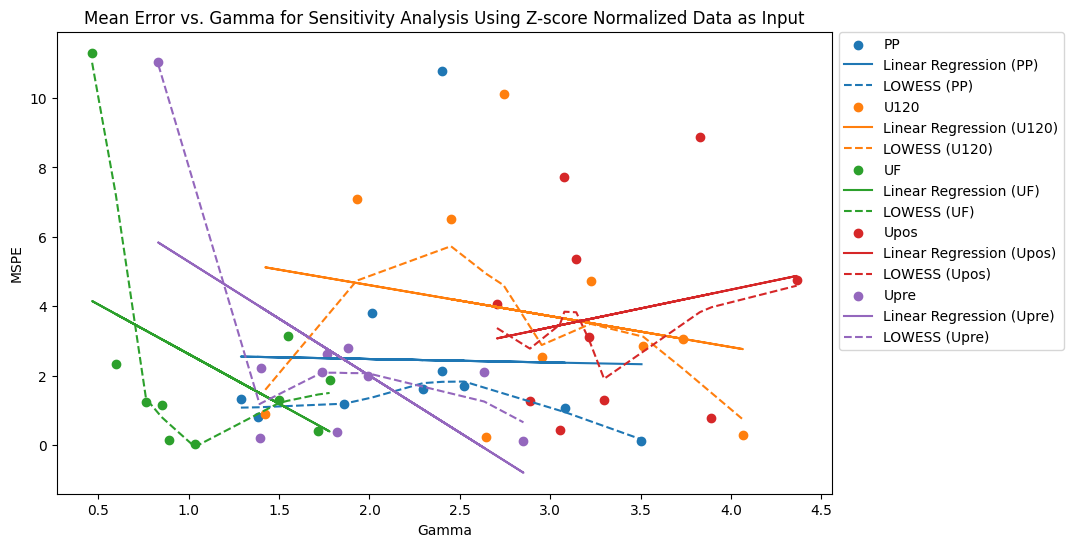

In [103]:
fig, axs = plt.subplots(1, figsize=(10, 6))

for category, group in all_splits_df_norm.groupby('Unnamed: 0'):
    # Calculate Regression Line
    slope, intercept, r_value, p_value, std_err = linregress(abs(group['gamma']), abs(group['mean error']))

    # Scatter Graph
    scatter = axs.scatter(abs(group['gamma']), abs(group['mean error']), label=category)
    color = scatter.get_facecolor()[0]  # Get color from scatter points

    # Regression Line
    axs.plot(abs(group['gamma']), slope * abs(group['gamma']) + intercept, linestyle='-', color=color, label=f'Linear Regression ({category})')

    # Calculate LOWESS Smoothing
    loess_smoothed = lowess(abs(group['mean error']), abs(group['gamma']), frac=0.6)
    axs.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], linestyle='--', color=color, label=f'LOWESS ({category})')

axs.set_title('Mean Error vs. Gamma for Sensitivity Analysis Using Z-score Normalized Data as Input')
axs.set_xlabel('Gamma')
axs.set_ylabel('MSPE')

axs.legend(bbox_to_anchor=(1, 1.015), loc='upper left')

plt.show()

## Sensitivity on Hidden Layers

In [ ]:
nodes = ['node 1', 'node 2', 'node 3', 'node 4', 'node 5', 'node 6']

with pd.ExcelWriter('node_sensitivity_analysis.xlsx', engine='openpyxl') as writer:

    all_splits_nodes_df = pd.DataFrame()

    for i in range(10):
        model = tf.keras.models.load_model(f'{DLNNe2e_file_paths}DLNNe2e_{i}.h5')
        test_indices = results[i]['DLNNe2e']['split']['test_indices']

        X_test = X_full.iloc[test_indices]
        y_test = y_full.iloc[test_indices]

        # Crear DataFrame para almacenar los resultados
        df = pd.DataFrame(columns=['mean error', 'std error', 'mean _percent_error', 'std_percent_error','gamma'])

        # Obtain the parametres from the second BN_layer
        bn_layer = model.layers[2]
        gamma = bn_layer.gamma.numpy()

        # Evaluar anulando un nodo a la vez
        for j in range(len(nodes)):
            weights = model.layers[1].get_weights()
            weights[0][:, j] = 0.0
            weights[1][j] = 0.0
            model.layers[1].set_weights(weights)

            y_pred_modified = model.predict(X_test)

            errors_mod = y_pred_modified.flatten() - y_test
            percent_errors_mod = (errors_mod/y_test)*100
            mean_errors_mod = np.mean(errors_mod)
            std_errors_mod = np.std(errors_mod)
            mean_percent_errors_mod = np.mean(percent_errors_mod)
            std_percent_errors_mod = np.std(percent_errors_mod)

            # Guardar los resultados en el DataFrame
            df.loc[nodes[j]] = [mean_errors_mod, std_errors_mod, mean_percent_errors_mod, std_percent_errors_mod, gamma[j]]

        # Concatenate all splits
        all_splits_nodes_df = pd.concat([all_splits_nodes_df, df], axis=0)

        # Escribir el DataFrame en la hoja correspondiente del Excel
        df.to_excel(writer, sheet_name=f'fold_{i}')

    abs_error = all_splits_nodes_df['mean error'].abs()
    abs_gamma = all_splits_nodes_df['gamma'].abs()
    all_splits_nodes_df['abs_error'] = abs_error
    all_splits_nodes_df['abs_gamma'] = abs_gamma

    # Escribir el DataFrame concatenado en una nueva hoja llamada 'all_splits'
    all_splits_nodes_df.to_excel(writer, sheet_name='all_splits')

In [84]:
all_splits_df_nodes = pd.read_excel('node_sensitivity_analysis.xlsx', sheet_name='all_splits')

In [85]:
all_splits_df_nodes

,Unnamed: 0,mean error,std error,mean _percent_error,std_percent_error,gamma,abs_error,abs_gamma
0,node 1,0.260923,14.253759,4.074432,20.161220,3.872470,0.260923,3.872470
1,node 2,-0.019569,14.367445,4.358978,20.937554,3.408238,0.019569,3.408238
2,node 3,2.199623,14.002066,8.990256,22.207303,3.492632,2.199623,3.492632
3,node 4,9.115590,15.260504,22.729847,28.058561,4.050473,9.115590,4.050473
4,node 5,10.313930,14.856689,24.881368,28.420194,-1.458136,10.313930,1.458136
5,node 6,10.718265,14.724695,25.592241,28.508220,1.154928,10.718265,1.154928
6,node 1,4.332581,9.227755,10.501341,18.293416,2.679669,4.332581,2.679669
7,node 2,0.605986,10.728206,6.164611,20.204615,4.741542,0.605986,4.741542
8,node 3,0.687597,14.495564,9.522503,28.055504,4.142737,0.687597,4.142737
9,node 4,2.186774,15.539644,13.892086,33.117570,3.270811,2.186774,3.270811


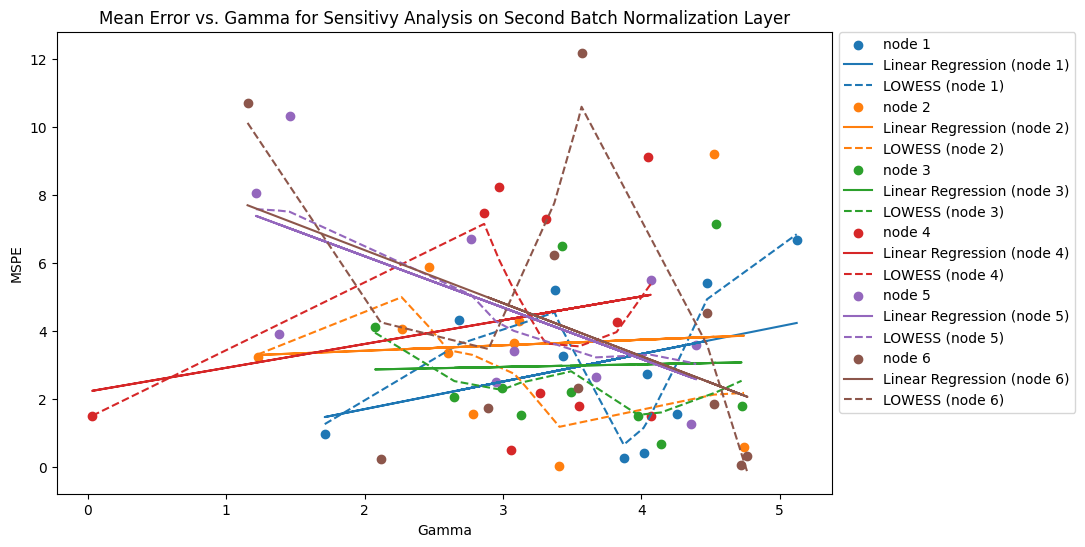

In [89]:
fig, axs = plt.subplots(1, figsize=(10, 6))

for category, group in all_splits_df_nodes.groupby('Unnamed: 0'):
    # Calculate Regression Line
    slope, intercept, r_value, p_value, std_err = linregress(abs(group['gamma']), abs(group['mean error']))

    # Scatter Graph
    scatter = axs.scatter(abs(group['gamma']), abs(group['mean error']), label=category)
    color = scatter.get_facecolor()[0]  # Get color from scatter points

    # Regression Line
    axs.plot(abs(group['gamma']), slope * abs(group['gamma']) + intercept, linestyle='-', color=color, label=f'Linear Regression ({category})')

    # Calculate LOWESS Smoothing
    loess_smoothed = lowess(abs(group['mean error']), abs(group['gamma']), frac=0.6)
    axs.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], linestyle='--', color=color, label=f'LOWESS ({category})')

axs.set_title('Mean Error vs. Gamma for Sensitivy Analysis on Second Batch Normalization Layer')
axs.set_xlabel('Gamma')
axs.set_ylabel('MSPE')

axs.legend(bbox_to_anchor=(1, 1.015), loc='upper left')

plt.show()